In [114]:
%matplotlib inline
import os
import numpy as np
import matplotlib as mpl

import readdy_learn.analyze.analyze as ana
import readdy_learn.analyze.basis as basis

import pynumtools.kmc as kmc

#mpl.rcParams['figure.figsize'] = (13, 13)
import matplotlib.pyplot as plt

In [115]:
def plot_overview(plot_functions, n_rows=2, n_cols=2, size_factor=1.):
    plt.figure(1, figsize=(5*n_cols*size_factor,3.5*n_rows*size_factor))
    n_plots = n_rows * n_cols
    idx = 1
    for pf in plot_functions:
        if idx > n_plots:
            break
        plt.subplot(n_rows, n_cols, idx)
        #plt.xscale("log")
        pf()
        plt.legend(loc="best")
        idx += 1

    #plt.subplots_adjust(top=0.88, bottom=0.08, left=0.10, right=0.95, hspace=0.4, wspace=0.35)
    plt.tight_layout(pad=0.6, w_pad=2.0, h_pad=2.0)

## regulation of two protein types A and B

In [131]:
# species DA, DB, MA, MB, A, B
n_species = 6
species_names = ["DA", "DB", "MA", "MB", "A", "B"]
desired_rates = np.array([
    1.8, # DA -> DA + MA, transcription A
    2.2, # DB -> DB + MB, transcription B
    2.1, # MA -> MA + A, translation A
    2.0, # MB -> MB + B, translation B
    4.,# MB + A -> A, A regulates B
    6.,# MA + B -> B, B regulates A
    1.3, # MA -> 0, decay
    1.5, # A -> 0, decay
    2.0, # MB -> 0, decay
    2.5, # B -> 0, decay
    0,
    0,
    #0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 # rest is nonsense
])

initial_states = [
    [1, 1, 0, 0, 0, 0], [1, 1, 3, 0, 0, 0], [1, 1, 1, 0, 4, 0], [1, 1, 0, 3, 0, 1],
    [1, 1, 2, 3, 7, 1], [1, 1, 2.0, 3, 0, 4.5], [1, 1, 3, 0.5, 1, 0]
]
initial_states = [np.array([arr]) for arr in initial_states]

In [132]:
ld_derivative_config = {
                'ld_derivative_atol': 1e-4,
                'ld_derivative_rtol': None,
                'ld_derivative_linalg_solver_maxit': 100000,
                'ld_derivative_alpha': 1e-1,
                'ld_derivative_solver': 'spsolve',
                'ld_derivative_linalg_solver_tol': 1e-10,
                'ld_derivative_use_preconditioner': False
            }
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(diffusivity=n_species*[[[0.]]], n_species=n_species, n_boxes=1,
                                      init_state=init_state, species_names=species_names)
    sys.add_fission("DA", "DA", "MA", np.array([desired_rates[0]])) # DA -> DA + MA transcription
    sys.add_fission("DB", "DB", "MB", np.array([desired_rates[1]])) # DB -> DB + MB transcription
    sys.add_fission("MA", "MA", "A", np.array([desired_rates[2]])) # MA -> MA + A translation
    sys.add_fission("MB", "MB", "B", np.array([desired_rates[3]])) # MB -> MB + B translation
    sys.add_fusion("MB", "A", "A", np.array([desired_rates[4]]))  # MB + A -> A, A regulates B
    sys.add_fusion("MA", "B", "B", np.array([desired_rates[5]]))  # MA + B -> B, B regulates A
    sys.add_decay("MA", np.array([desired_rates[6]])) # MA -> 0 mRNA A decay
    sys.add_decay("A", np.array([desired_rates[7]])) # A -> 0 protein decay
    sys.add_decay("MB", np.array([desired_rates[8]])) # MB -> 0 mRNA B decay
    sys.add_decay("B", np.array([desired_rates[9]])) # B -> 0 protein decay
    
    return sys

def get_bfc():
    bfc = basis.BasisFunctionConfiguration(n_species)
    bfc.add_fission(0, 0, 2) # 0 DA -> DA + MA, transcription A
    bfc.add_fission(1, 1, 3) # 1 DB -> DB + MB, transcription B
    bfc.add_fission(2, 2, 4) # 2 MA -> MA + A, translation A
    bfc.add_fission(3, 3, 5) # 3 MB -> MB + B, translation B
    bfc.add_fusion(3, 4, 4)  # 4 MB + A -> A, A regulates B
    bfc.add_fusion(2, 5, 5)  # 5 MA + B -> B, B regulates A
    bfc.add_decay(2) # 6 MA -> 0, decay
    bfc.add_decay(4) # 7 A -> 0, decay
    bfc.add_decay(3) # 8 MB -> 0, decay
    bfc.add_decay(5) # 9 B -> 0, decay
    
    # some more stuff with A
    #bfc.add_fusion(0, 2, 0)  # 10 DA + MA -> DA, nope
    #bfc.add_conversion(0, 2) # 11 DA -> MA, nope
    #bfc.add_conversion(2, 0) # 12 MA -> DA, nope
    #bfc.add_conversion(0, 4) # 13 DA -> A, nope
    #bfc.add_conversion(4, 0) # 14 A -> DA, nope
    #bfc.add_conversion(2, 4) # 15 MA -> A, nope
    #bfc.add_conversion(4, 2) # 16 A -> MA, nope
    #bfc.add_fusion(0, 4, 2) # 17 DA + A -> MA, nope
    #bfc.add_fission(2, 0, 4) # 18 MA -> DA + A, nope
    #bfc.add_fusion(0, 2, 4) # 19 DA + MA -> A, nope
    #bfc.add_fission(4, 0, 2) # 20 A -> DA + MA, nope
    
    # some more stuff with B
    #bfc.add_fusion(1, 3, 1)  # 21 DB + MB -> DB, nope
    #bfc.add_conversion(1, 3) # 22 DB -> MB, nope
    #bfc.add_conversion(3, 1) # 23 MB -> DB, nope
    #bfc.add_conversion(1, 5) # 24 DB -> B, nope
    #bfc.add_conversion(5, 1) # 25 B -> DB, nope
    #bfc.add_conversion(3, 5) # 26 MB -> B, nope
    #bfc.add_conversion(5, 3) # 27 B -> MB, nope
    #bfc.add_fusion(1, 5, 3) # 28 DB + B -> MB, nope
    #bfc.add_fission(3, 1, 5) # 29 MB -> DB + B, nope
    #bfc.add_fusion(1, 3, 5) # 30 DB + MB -> B, nope
    #bfc.add_fission(5, 1, 3) # 31 B -> DB + MB, nope
    
    # some more cross nonsense
    bfc.add_fusion(2, 4, 4)  # 32 MA + A -> A, A regulates A, nope
    bfc.add_fusion(3, 5, 5)  # 33 MB + B -> B, B regulates B, nope
    
    assert bfc.n_basis_functions == len(desired_rates), \
        "got {} basis functions but only {} desired rates".format(bfc.n_basis_functions, len(desired_rates))
    return bfc

In [133]:
noise_variance = 0.0001
target_time = 4.
train_n=3
test_n=6
traj_n_s = [train_n, test_n]

In [134]:
analysis = ana.ReactionAnalysis(get_bfc(), desired_rates, initial_states, set_up_system,  
                                fname_prefix='gene_cross_regulation', 
                                fname_postfix='1',  n_species=n_species, target_n_counts=1000, timestep=1e-3,
                                ld_derivative_config=ld_derivative_config, recompute_traj=False)

train


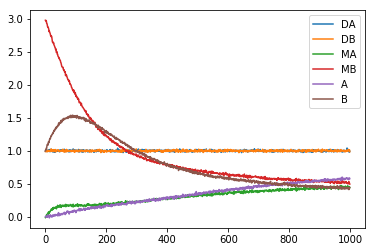

test


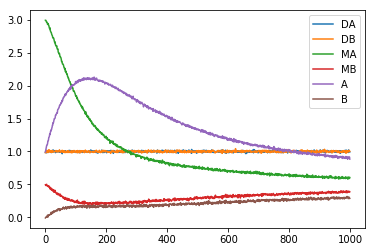

In [135]:
def plot_and_persist_lma_traj(t):
    plt.plot(t.counts[:, 0], label=species_names[0])
    plt.plot(t.counts[:, 1], label=species_names[1])
    plt.plot(t.counts[:, 2], label=species_names[2])
    plt.plot(t.counts[:, 3], label=species_names[3])
    plt.plot(t.counts[:, 4], label=species_names[4])
    plt.plot(t.counts[:, 5], label=species_names[5])
    plt.legend(loc="best")
    plt.show()
    t.persist()

print("train")
t = analysis.generate_or_load_traj_lma(train_n, target_time, noise_variance=noise_variance)
plot_and_persist_lma_traj(t)
print("test")
t = analysis.generate_or_load_traj_lma(test_n, target_time, noise_variance=noise_variance)
plot_and_persist_lma_traj(t)

dna species 0 -> alpha in (100, 100000)

other species -> alpha lower than 1.

In [136]:
analysis.calculate_lma_fd_derivative(train_n, target_time)
analysis.calculate_lma_fd_derivative(test_n, target_time)

Dont have derivative (got 0 but need 6)
Dont have derivative (got 0 but need 6)


## species mRNA, Protein TRAIN

In [137]:
ttraj = analysis.get_traj(train_n)
ttraj.fd_derivatives()
ttraj.persist()

In [138]:
analysis.obtain_lma_trajectories(
    target_time,
    noise_variance=noise_variance,
    species=[2, 3, 4, 5],
    # alphas=np.linspace(0.0005, 0.01, num=8),
    alphas=np.array([0.001, 0.0011]),
    verbose=True, 
    atol=5e-5,
    maxit=50, 
    search_depth=1, 
    selection=[train_n],
    #subdivisions=3,
    override=False,
)

obtaining derivative for species [2 3 4 5]
traj already contains derivatives and override is False, skip this


## species mRNA, Protein TEST

In [139]:
ttraj = analysis.get_traj(test_n)
ttraj.fd_derivatives()
ttraj.persist()

In [140]:
analysis.obtain_lma_trajectories(
    target_time,
    noise_variance=noise_variance,
    species=[2, 3, 4, 5],
    # alphas=np.linspace(0.0005, 0.01, num=8),
    alphas=np.array([0.001, 0.0011]),
    verbose=True, 
    atol=5e-5,
    maxit=50, 
    search_depth=1, 
    selection=[test_n],
    #subdivisions=3,
    override=False,
)

obtaining derivative for species [2 3 4 5]
traj already contains derivatives and override is False, skip this


## species DNA

In [141]:
if False:
    analysis.obtain_lma_trajectories(
        target_time,
        noise_variance=noise_variance,
        species=[0],
        # alphas=np.linspace(0.0001, 1., num=8),
        alphas=np.linspace(1e-1, 1e-0, num=8), #np.array([1,.5,10]),
        verbose=True, 
        atol=5e-7,
        maxit=500, 
        search_depth=3, 
        selection=traj_n_s,
        override=False,
        reuse_deriv=False)

In [142]:
if False:
    analysis.obtain_lma_trajectories(
        target_time,
        noise_variance=noise_variance,
        species=[1],
        # alphas=np.linspace(0.0001, 1., num=8),
        alphas=np.linspace(1e-4, 1e-3, num=8), #np.array([1,.5,10]), # @todo slightly larger
        verbose=True, 
        atol=5e-7,
        maxit=500, 
        search_depth=1, 
        selection=traj_n_s,
        override=False,
        reuse_deriv=False)

In [143]:
for t in traj_n_s:
    traj = analysis.get_traj(t)
    traj.separate_derivs[0] = np.zeros_like(traj.separate_derivs[2])
    traj.separate_derivs[1] = np.zeros_like(traj.separate_derivs[2])
    traj.persist()

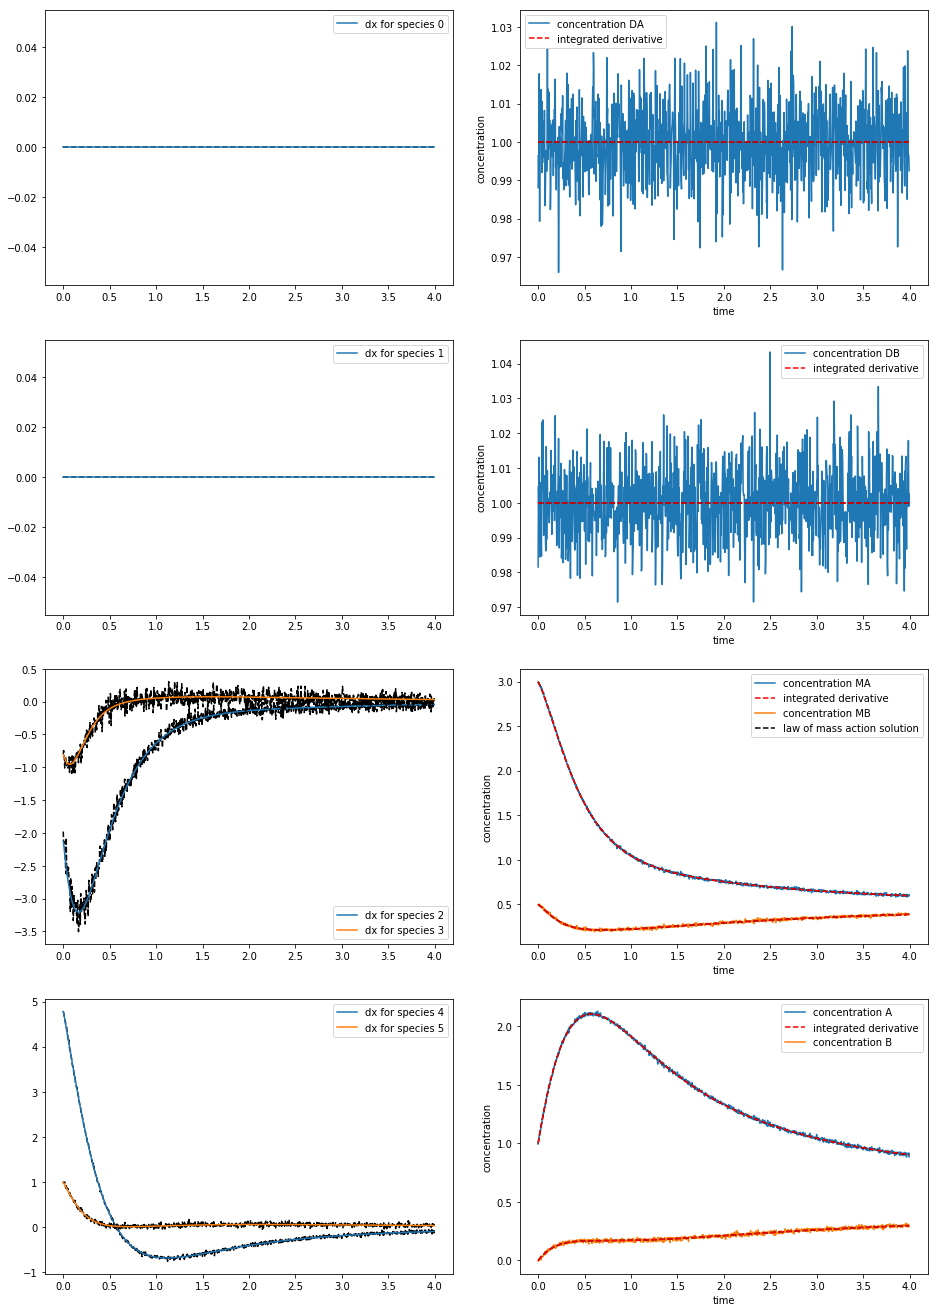

In [144]:
traj_number=test_n
pfs = [
    lambda t=traj_number: analysis.plot_derivatives(t, species=[0]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[0]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[1]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[1]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[2, 3]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[2, 3]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[4, 5]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[4, 5])
]
plot_overview(pfs, n_cols=2, n_rows=4, size_factor=1.3)
plt.show()

train_n 3 test_n 6


IntProgress(value=0, max=127)

params: alpha=1.2600000000000002e-06, l1=0.0 with corresponding score 0.025359140845828694
train_n 3
optimization problem did exit successfully (alpha=1.2600000000000002e-06, lambda=0.0)!
status 0: Optimization terminated successfully.
72 / 30000 iterations


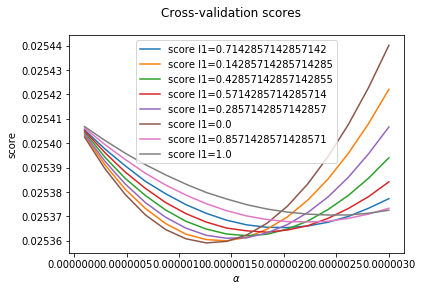

In [163]:
est_rates, cv_res = ana.do_the_cv(
    analysis,
    train_n=train_n,
    test_n=test_n,
    alphas=np.linspace(0.0000001,0.000003,num=16),
    #alphas=np.array([0.000000001,0.0000000011]),
    l1_ratios=np.linspace(0., 1., num=8),
    recompute=True
)
ana.plot_cv_results(cv_res, mainscore=0, best_params_ix_l1=None)

In [164]:
if False:
    est_rates_lsq = analysis.least_squares(3)

In [168]:
est_rates

array([1.58132946, 1.57279769, 1.94904752, 1.99589879, 2.29267551,
       5.19560265, 1.10889887, 1.36901223, 1.67109466, 2.49450412,
       0.10636066, 0.08717357])

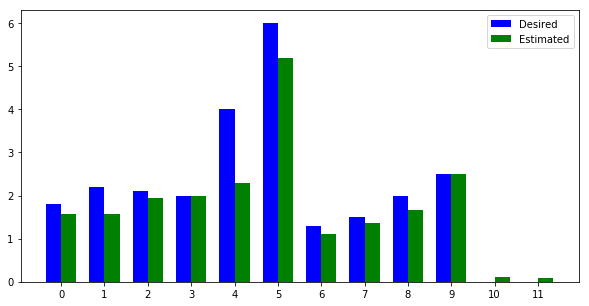

In [165]:
ana.plot_rates_bar(desired_rates, est_rates)

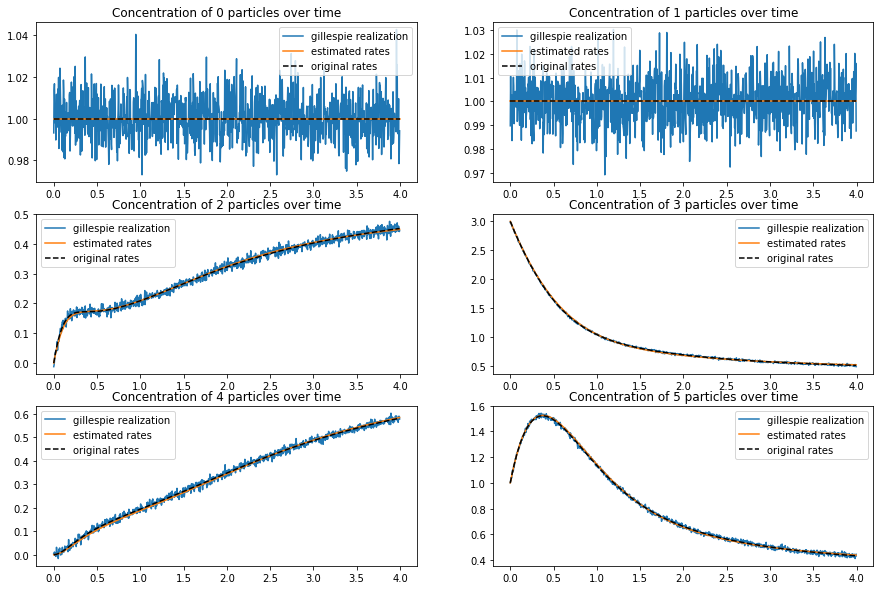

In [166]:
analysis.plot_results(train_n, est_rates)

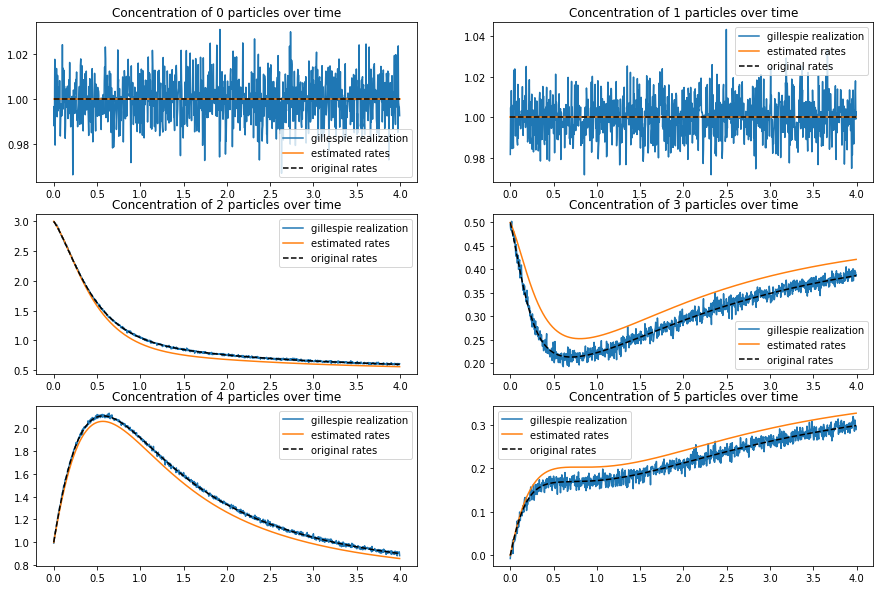

In [167]:
analysis.plot_results(test_n, est_rates)

## Throw away unnecessary basis functions and start over

In [201]:
# species DA, DB, MA, MB, A, B
n_species = 6
species_names = ["DA", "DB", "MA", "MB", "A", "B"]
desired_rates = np.array([
    1.8, # DA -> DA + MA, transcription A
    2.2, # DB -> DB + MB, transcription B
    2.1, # MA -> MA + A, translation A
    2.0, # MB -> MB + B, translation B
    4.,# MB + A -> A, A regulates B
    6.,# MA + B -> B, B regulates A
    1.3, # MA -> 0, decay
    1.5, # A -> 0, decay
    2.0, # MB -> 0, decay
    2.5, # B -> 0, decay
    #0,
    #0,
    #0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0 # rest is nonsense
])

initial_states = [
    [1, 1, 0, 0, 0, 0], [1, 1, 3, 0, 0, 0], [1, 1, 1, 0, 4, 0], [1, 1, 0, 3, 0, 1],
    [1, 1, 2, 3, 7, 1], [1, 1, 2.0, 3, 0, 4.5], [1, 1, 3, 0.5, 1, 0]
]
initial_states = [np.array([arr]) for arr in initial_states]

In [202]:
ld_derivative_config = {
                'ld_derivative_atol': 1e-4,
                'ld_derivative_rtol': None,
                'ld_derivative_linalg_solver_maxit': 100000,
                'ld_derivative_alpha': 1e-1,
                'ld_derivative_solver': 'spsolve',
                'ld_derivative_linalg_solver_tol': 1e-10,
                'ld_derivative_use_preconditioner': False
            }
def set_up_system(init_state):
    sys = kmc.ReactionDiffusionSystem(diffusivity=n_species*[[[0.]]], n_species=n_species, n_boxes=1,
                                      init_state=init_state, species_names=species_names)
    sys.add_fission("DA", "DA", "MA", np.array([desired_rates[0]])) # DA -> DA + MA transcription
    sys.add_fission("DB", "DB", "MB", np.array([desired_rates[1]])) # DB -> DB + MB transcription
    sys.add_fission("MA", "MA", "A", np.array([desired_rates[2]])) # MA -> MA + A translation
    sys.add_fission("MB", "MB", "B", np.array([desired_rates[3]])) # MB -> MB + B translation
    sys.add_fusion("MB", "A", "A", np.array([desired_rates[4]]))  # MB + A -> A, A regulates B
    sys.add_fusion("MA", "B", "B", np.array([desired_rates[5]]))  # MA + B -> B, B regulates A
    sys.add_decay("MA", np.array([desired_rates[6]])) # MA -> 0 mRNA A decay
    sys.add_decay("A", np.array([desired_rates[7]])) # A -> 0 protein decay
    sys.add_decay("MB", np.array([desired_rates[8]])) # MB -> 0 mRNA B decay
    sys.add_decay("B", np.array([desired_rates[9]])) # B -> 0 protein decay
    
    return sys

def get_bfc():
    bfc = basis.BasisFunctionConfiguration(n_species)
    bfc.add_fission(0, 0, 2) # 0 DA -> DA + MA, transcription A
    bfc.add_fission(1, 1, 3) # 1 DB -> DB + MB, transcription B
    bfc.add_fission(2, 2, 4) # 2 MA -> MA + A, translation A
    bfc.add_fission(3, 3, 5) # 3 MB -> MB + B, translation B
    bfc.add_fusion(3, 4, 4)  # 4 MB + A -> A, A regulates B
    bfc.add_fusion(2, 5, 5)  # 5 MA + B -> B, B regulates A
    bfc.add_decay(2) # 6 MA -> 0, decay
    bfc.add_decay(4) # 7 A -> 0, decay
    bfc.add_decay(3) # 8 MB -> 0, decay
    bfc.add_decay(5) # 9 B -> 0, decay
    
    # some more stuff with A
    #bfc.add_fusion(0, 2, 0)  # 10 DA + MA -> DA, nope
    #bfc.add_conversion(0, 2) # 11 DA -> MA, nope
    #bfc.add_conversion(2, 0) # 12 MA -> DA, nope
    #bfc.add_conversion(0, 4) # 13 DA -> A, nope
    #bfc.add_conversion(4, 0) # 14 A -> DA, nope
    #bfc.add_conversion(2, 4) # 15 MA -> A, nope
    #bfc.add_conversion(4, 2) # 16 A -> MA, nope
    #bfc.add_fusion(0, 4, 2) # 17 DA + A -> MA, nope
    #bfc.add_fission(2, 0, 4) # 18 MA -> DA + A, nope
    #bfc.add_fusion(0, 2, 4) # 19 DA + MA -> A, nope
    #bfc.add_fission(4, 0, 2) # 20 A -> DA + MA, nope
    
    # some more stuff with B
    #bfc.add_fusion(1, 3, 1)  # 21 DB + MB -> DB, nope
    #bfc.add_conversion(1, 3) # 22 DB -> MB, nope
    #bfc.add_conversion(3, 1) # 23 MB -> DB, nope
    #bfc.add_conversion(1, 5) # 24 DB -> B, nope
    #bfc.add_conversion(5, 1) # 25 B -> DB, nope
    #bfc.add_conversion(3, 5) # 26 MB -> B, nope
    #bfc.add_conversion(5, 3) # 27 B -> MB, nope
    #bfc.add_fusion(1, 5, 3) # 28 DB + B -> MB, nope
    #bfc.add_fission(3, 1, 5) # 29 MB -> DB + B, nope
    #bfc.add_fusion(1, 3, 5) # 30 DB + MB -> B, nope
    #bfc.add_fission(5, 1, 3) # 31 B -> DB + MB, nope
    
    # some more cross nonsense
    #bfc.add_fusion(2, 4, 4)  # 32 MA + A -> A, A regulates A, nope
    #bfc.add_fusion(3, 5, 5)  # 33 MB + B -> B, B regulates B, nope
    
    assert bfc.n_basis_functions == len(desired_rates), \
        "got {} basis functions but only {} desired rates".format(bfc.n_basis_functions, len(desired_rates))
    return bfc

In [203]:
analysis = ana.ReactionAnalysis(get_bfc(), desired_rates, initial_states, set_up_system,  
                                fname_prefix='gene_cross_regulation', 
                                fname_postfix='2',  n_species=n_species, target_n_counts=4000, timestep=1e-3,
                                ld_derivative_config=ld_derivative_config, recompute_traj=False)

train


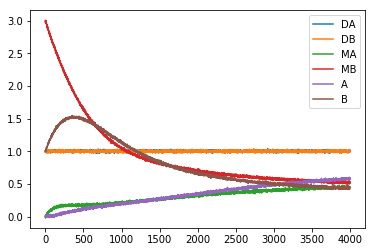

test


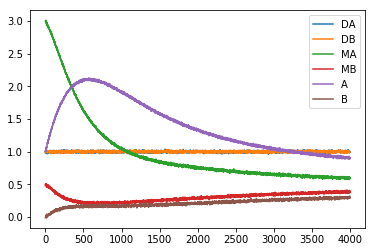

In [204]:
def plot_and_persist_lma_traj(t):
    plt.plot(t.counts[:, 0], label=species_names[0])
    plt.plot(t.counts[:, 1], label=species_names[1])
    plt.plot(t.counts[:, 2], label=species_names[2])
    plt.plot(t.counts[:, 3], label=species_names[3])
    plt.plot(t.counts[:, 4], label=species_names[4])
    plt.plot(t.counts[:, 5], label=species_names[5])
    plt.legend(loc="best")
    plt.show()
    t.persist()

print("train")
t = analysis.generate_or_load_traj_lma(train_n, target_time, noise_variance=noise_variance)
plot_and_persist_lma_traj(t)
print("test")
t = analysis.generate_or_load_traj_lma(test_n, target_time, noise_variance=noise_variance)
plot_and_persist_lma_traj(t)

In [205]:
analysis.calculate_lma_fd_derivative(train_n, target_time)
analysis.calculate_lma_fd_derivative(test_n, target_time)

Dont have derivative (got 0 but need 6)
Dont have derivative (got 0 but need 6)


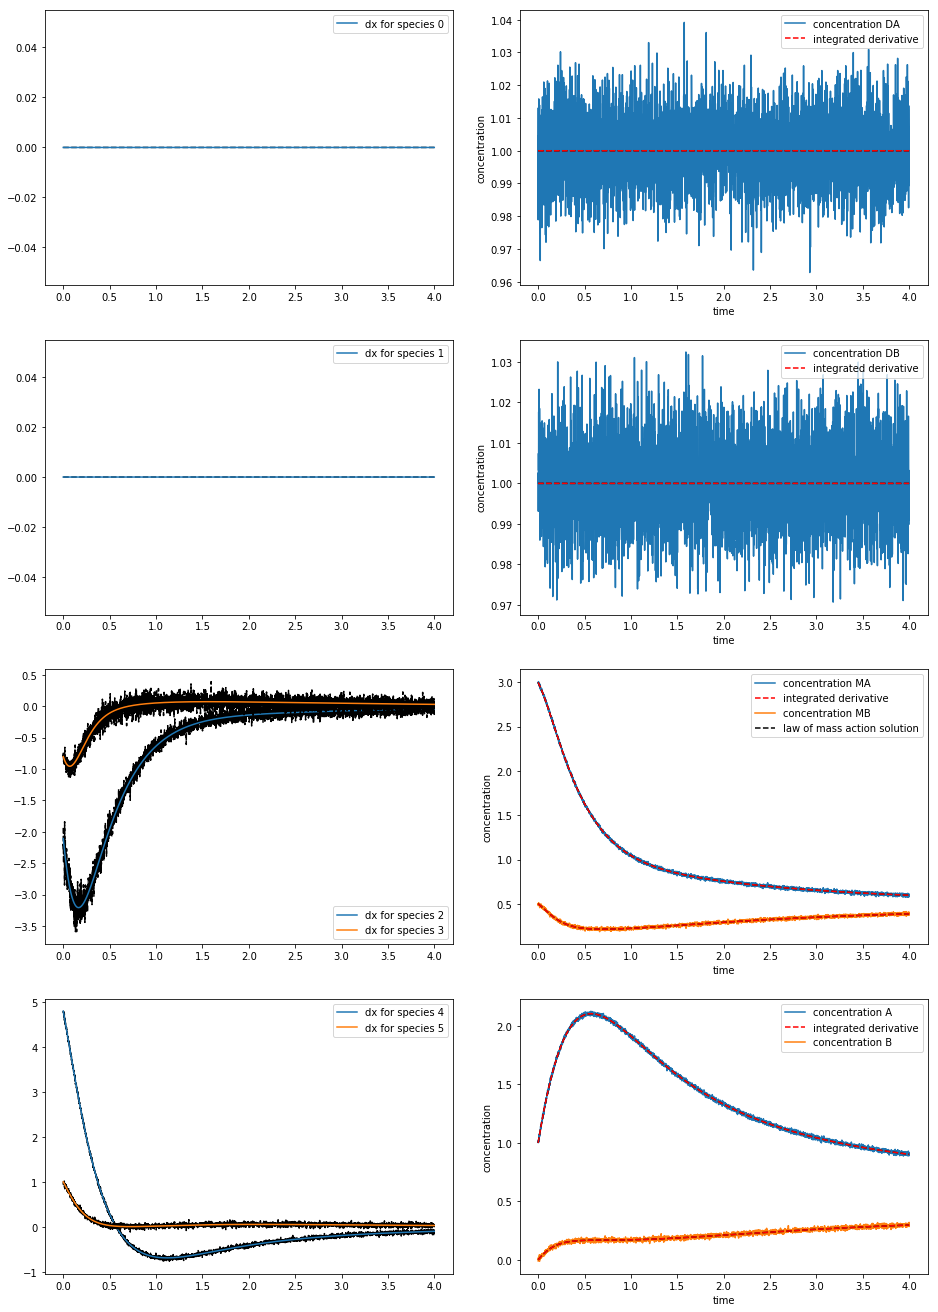

In [206]:
traj_number=test_n
pfs = [
    lambda t=traj_number: analysis.plot_derivatives(t, species=[0]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[0]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[1]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[1]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[2, 3]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[2, 3]),
    lambda t=traj_number: analysis.plot_derivatives(t, species=[4, 5]),
    lambda t=traj_number: analysis.plot_concentration_curves(t, species=[4, 5])
]
plot_overview(pfs, n_cols=2, n_rows=4, size_factor=1.3)
plt.show()

train_n 3 test_n 6


IntProgress(value=0, max=127)

params: alpha=1e-07, l1=1.0 with corresponding score 0.026768466353488996
train_n 3
optimization problem did exit successfully (alpha=1e-07, lambda=1.0)!
status 0: Optimization terminated successfully.
55 / 30000 iterations


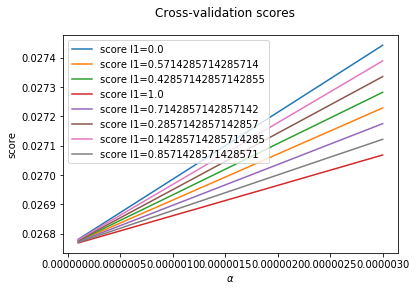

In [207]:
est_rates, cv_res = ana.do_the_cv(
    analysis,
    train_n=train_n,
    test_n=test_n,
    alphas=np.linspace(0.0000001,0.000003,num=16),
    #alphas=np.array([0.000000001,0.0000000011]),
    l1_ratios=np.linspace(0., 1., num=8),
    recompute=True
)
ana.plot_cv_results(cv_res, mainscore=0, best_params_ix_l1=None)

In [208]:
lsq_rates = analysis.solve(test_n, 0., 1.)
lsq_rates

optimization problem did exit successfully (alpha=0.0, lambda=1.0)!
status 0: Optimization terminated successfully.
51 / 30000 iterations


array([1.7084372 , 1.93504458, 2.0974564 , 1.90423344, 3.57613847,
       5.35590516, 1.32940378, 1.49809267, 1.6897219 , 2.36748235])

In [209]:
est_rates

array([1.5999156 , 1.71197919, 1.96218268, 1.99529095, 2.53231339,
       5.21978952, 1.19588794, 1.37965717, 1.8452623 , 2.49394334])

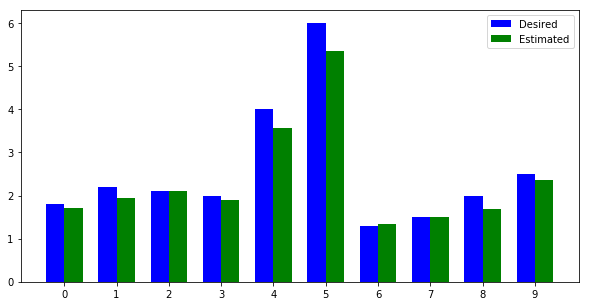

In [213]:
ana.plot_rates_bar(desired_rates, lsq_rates)

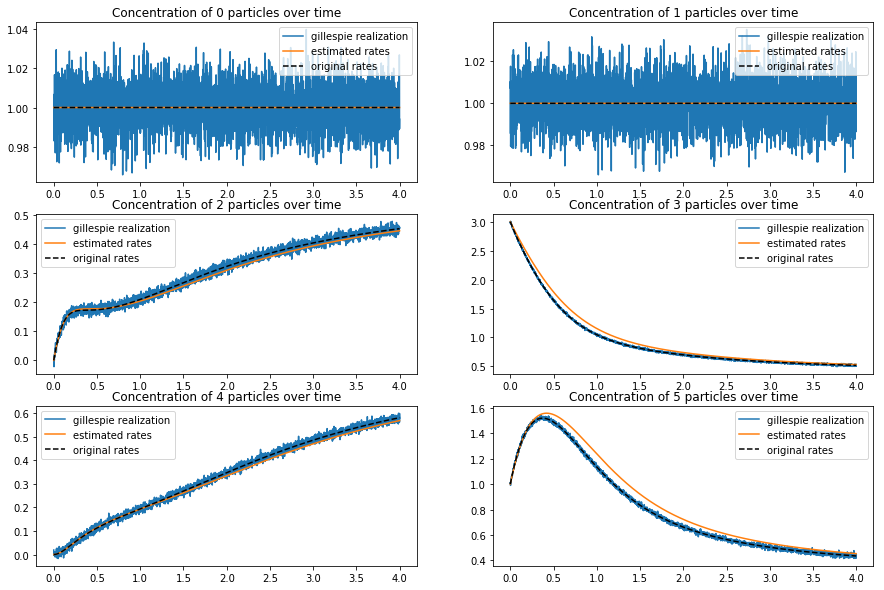

In [214]:
analysis.plot_results(train_n, lsq_rates)

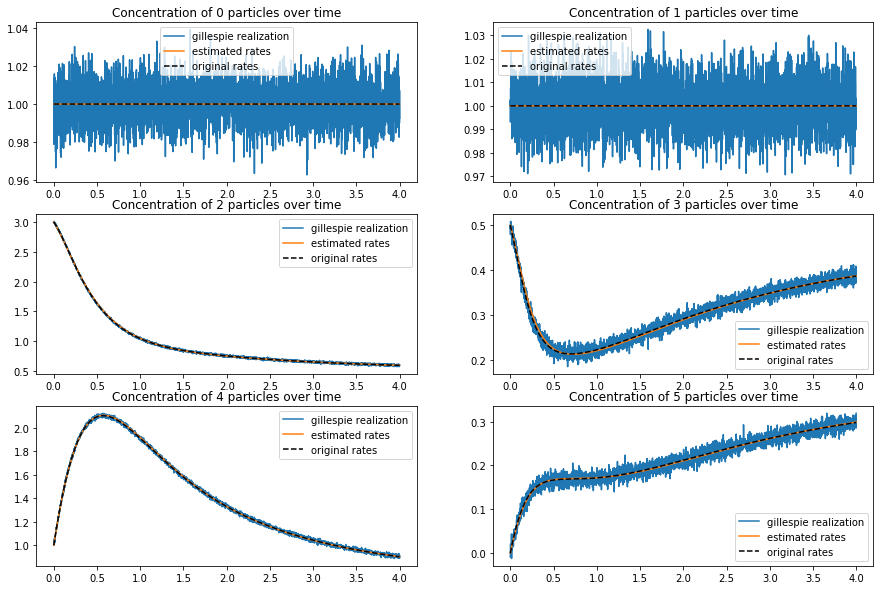

In [215]:
analysis.plot_results(test_n, lsq_rates)